In [1]:
!pip install jiwer

In [2]:
from jiwer import *
import os
from pathlib import Path
from google.colab import drive
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def get_df_ready(ground_truth_df,base_transcripts_df):

  df_merged = ground_truth_df.merge(base_transcripts_df, left_on='path', right_on='filename', how='inner')
  df_merged = df_merged.rename(columns={'transcribed_text': 'model_transcription', 'sentence': 'ground_truth'})
  new_df = df_merged[['client_id','path','ground_truth','age','model_transcription']].copy()

  def normalize_transcription(text):
    if text is None:
      return ""
    text = str(text)

    # unify whitespace
    text = text.replace("\n", " ")

    # prefer speaker correction before removing brackets: "word [: replacement]" -> "replacement"
    text = re.sub(r'\b\w+\s*\[:\s*([^\]]+)\]', r'\1', text)

    # remove remaining bracket annotations: [/], [//], [* ...], [: ...], etc.
    text = re.sub(r'\[[^\]]+\]', ' ', text)

    # remove angle-bracket fragments/retraces: <...>
    text = re.sub(r'<[^>]+>', ' ', text)

    # micro-pause markers: (.), (..), (...)
    text = re.sub(r'\(\.*\)', ' ', text)

    # normalize "(g)" inflection: askin(g) -> asking, dryin(g) -> drying
    text = re.sub(r'([A-Za-z]+)\(g\)', r'\1g', text)

    # remove chat codes: &=..., &-..., &+...
    text = re.sub(r'&[-=+][^\s.]+', ' ', text)

    # drop "+..." fragments and lone +tokens
    text = re.sub(r'\+\S*', ' ', text)

    # colloquial fixes
    text = re.sub(r'\bhafta\b', 'have to', text, flags=re.IGNORECASE)
    text = re.sub(r'\bhadta\b', 'had to', text, flags=re.IGNORECASE)
    text = re.sub(r'\bwanna\b', 'want to', text, flags=re.IGNORECASE)

    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

  transformation = Compose([
    normalize_transcription,
    ExpandCommonEnglishContractions(),
    RemovePunctuation(),
    ToLowerCase(),
    RemoveMultipleSpaces(),
    Strip()
  ])
  #Age word -> numeric decade map
  AGE_CANON = {
      "teens": 10, "teen": 10, "10s": 10, "10": 10,
      "twenties": 20, "twenty": 20, "20s": 20, "20": 20,
      "thirties": 30, "thirty": 30, "30s": 30, "30": 30,
      "forties": 40, "forty": 40, "40s": 40, "40": 40,
      "fifties": 50, "fifty": 50, "50s": 50, "50": 50,
      "sixties": 60, "sixty": 60, "60s": 60, "60": 60,
      "seventies": 70, "seventy": 70, "70s": 70, "70": 70,
      "eighties": 80, "eighty": 80, "80s": 80, "80": 80,
      "nineties": 90, "ninety": 90, "90s": 90, "90": 90,
  }
  # common misspellings
  AGE_TYPO = {
      "fifities": "fifties",
      "sixities": "sixties",
      "fourties": "forties",
      "thirites": "thirties",
      "fourtees": "forties",
      "fourties": "forties",
  }

  def age_word_to_decade(x):
      if x is None or (isinstance(x, float) and np.isnan(x)):
          return np.nan
      s = str(x).strip().lower()
      s = s.replace("-", "").replace(" ", "")
      s = AGE_TYPO.get(s, s)

      # numeric pattern like "60s" or "60"
      m = re.fullmatch(r'(\d{2})s?', s)
      if m:
        return int(m.group(1))

      return AGE_CANON.get(s, np.nan)
  df = new_df.copy()
  df["gt_clean"]  = df["ground_truth"].fillna("").map(transformation)
  df["hyp_clean"] = df["model_transcription"].fillna("").map(transformation)
  df["decade"]    = df["age"].map(age_word_to_decade).astype("Int64")
  df["age2"]      = np.where(df["decade"] >= 60, "60_and_above", "under_60")

  return df

In [4]:
base_transcripts_df = pd.read_csv('/content/drive/My Drive/Capstone/Data/Common Voices CSVs/transcripts_from_prefix_10082025.csv')
ground_truth_df = pd.read_csv('/content/drive/My Drive/Capstone/Data/Common Voices CSVs/common_voices_23_train_with_validated_votes.csv')
new_df = get_df_ready(ground_truth_df,base_transcripts_df)
new_df.head()

/tmp/ipython-input-2257280848.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  ground_truth_df = pd.read_csv('/content/drive/My Drive/Capstone/Data/Common Voices CSVs/common_voices_23_train_with_validated_votes.csv')


,client_id,path,ground_truth,age,model_transcription,gt_clean,hyp_clean,decade,age2
0,d2275471a5593c9b2a633d1725baf31d790d3b1a7bfc7d...,common_voice_en_32801004.mp3,DenG returned to Liberia and studied business ...,sixties,Then G returned to Liberia and studied busine...,deng returned to liberia and studied business ...,then g returned to liberia and studied busines...,60,60_and_above
1,d2275471a5593c9b2a633d1725baf31d790d3b1a7bfc7d...,common_voice_en_32801005.mp3,The museum used to be the old Tainan watercour...,sixties,The museum used to be the old time-and-water ...,the museum used to be the old tainan watercour...,the museum used to be the old timeandwater cou...,60,60_and_above
2,d2275471a5593c9b2a633d1725baf31d790d3b1a7bfc7d...,common_voice_en_32801006.mp3,He was succeeded by Rev.,sixties,He was succeeded by Rev.,he was succeeded by rev,he was succeeded by rev,60,60_and_above
3,d32584f6c43587b80efb24ec2cef7fed5399146b2035b3...,common_voice_en_40124657.mp3,Chavalit began his political activity while st...,sixties,Shabbat began his political activity while st...,chavalit began his political activity while st...,shabbat began his political activity while sti...,60,60_and_above
4,d32584f6c43587b80efb24ec2cef7fed5399146b2035b3...,common_voice_en_40124658.mp3,Luke Hannigan continues to write music under a...,sixties,Luke Halligan continues to write music under ...,luke hannigan continues to write music under a...,luke halligan continues to write music under a...,60,60_and_above


In [5]:
len(new_df)

127124

#Macro: Aggregates data for each unique speaker (client_id)

In [6]:
# check: each client has a single decade (if multiple, take the mode)
def mode_or_first(s):
    try:
        return s.mode().iat[0]
    except Exception:
        return s.dropna().iloc[0] if len(s.dropna()) else np.nan

agg = (
    new_df.groupby("client_id")
      .agg(
          gt_concat=("gt_clean", lambda s: " ".join(s)),
          hyp_concat=("hyp_clean", lambda s: " ".join(s)),
          decade=("decade", mode_or_first),
          n_utts=("path", "count")
      )
      .reset_index()
)

def compute_measures_row(row):
    m = process_words(row["gt_concat"], row["hyp_concat"])

    return pd.Series({
        "wer": m.wer,
        "mer": m.mer,
        "wil": m.wil,
        "wip": m.wip,
        "w_hits": m.hits
    })

metrics_spk = agg.join(agg.apply(compute_measures_row, axis=1))
metrics_spk["age2"] = np.where(metrics_spk["decade"] >= 60, "60_and_above", "under_60")



# ---------------------------------------------------------
# Summaries:
#    (1) by two groups (<60 vs ≥60): macro over speakers
#    (2) by numeric decade: macro over speakers, sorted

by_age2 = (
    metrics_spk.groupby("age2")
    .agg(
        n_speakers=("client_id", "nunique"),
        n_utts=("n_utts", "sum"),
        wer=("wer", "mean"),
        mer=("mer", "mean"),
        wil=("wil", "mean"),
        wip=("wip", "mean"),
        w_hits=("w_hits", "mean"),
    )
    .reset_index()
)

by_decade = (
    metrics_spk.dropna(subset=["decade"])
    .groupby("decade")
    .agg(
        n_speakers=("client_id", "nunique"),
        n_utts=("n_utts", "sum"),
        wer=("wer", "mean"),
        mer=("mer", "mean"),
        wil=("wil", "mean"),
        wip=("wip", "mean"),
        w_hits=("w_hits", "mean"),
    )
    .sort_index()
    .reset_index()
)


print("== Two groups (<60 vs ≥60): macro over speakers ==")
display(by_age2.round(4))

print("\n== By decade: macro over speakers, ascending ==")
display(by_decade.round(4))


== Two groups (<60 vs ≥60): macro over speakers ==


,age2,n_speakers,n_utts,wer,mer,wil,wip,w_hits
0,60_and_above,809,63569,0.1183,0.1135,0.1867,0.8133,756.2472
1,under_60,7140,63555,0.1558,0.1334,0.2117,0.7883,81.6216



== By decade: macro over speakers, ascending ==


,decade,n_speakers,n_utts,wer,mer,wil,wip,w_hits
0,20,3848,29025,0.1775,0.1432,0.2255,0.7745,68.0431
1,30,1821,16528,0.1359,0.1264,0.2016,0.7984,84.1538
2,40,909,12397,0.1250,0.1187,0.1932,0.8068,125.0440
3,50,562,5605,0.1207,0.1129,0.1807,0.8193,96.1548
4,60,562,56444,0.1202,0.1149,0.1881,0.8119,967.8114
5,70,212,5915,0.1146,0.1112,0.1847,0.8153,266.2500
6,80,30,1032,0.1015,0.0980,0.1632,0.8368,322.8333
7,90,5,178,0.1591,0.1536,0.2459,0.7541,352.8000


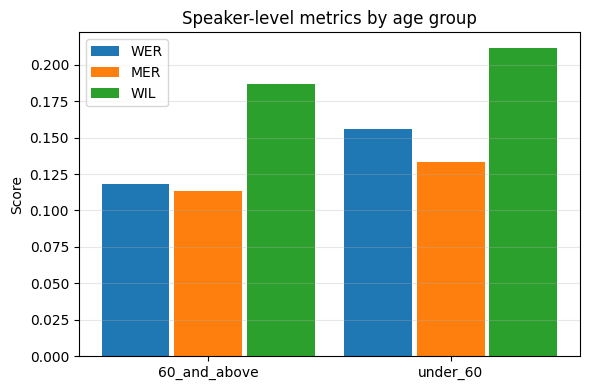

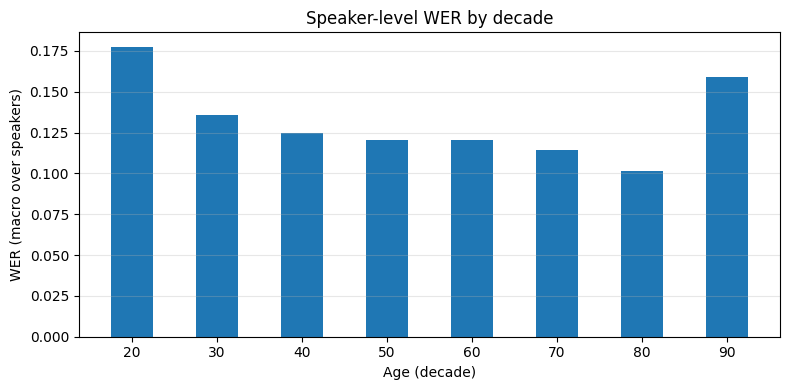

In [7]:
# Plots

# Two-group bars
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(by_age2))
ax.bar(x - 0.3, by_age2["wer"], width=0.28, label="WER")
ax.bar(x - 0.0, by_age2["mer"], width=0.28, label="MER")
ax.bar(x + 0.3, by_age2["wil"], width=0.28, label="WIL")
ax.set_xticks(x, by_age2["age2"])
ax.set_ylabel("Score")
ax.set_title("Speaker-level metrics by age group")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()

# Per-decade bars
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(by_decade["decade"].astype(int), by_decade["wer"], width=5, align="center")
ax.set_xlabel("Age (decade)")
ax.set_ylabel("WER (macro over speakers)")
ax.set_title("Speaker-level WER by decade")
ax.set_xticks(by_decade["decade"].astype(int))
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()


In [8]:
def bootstrap_ci_mean(x, B=10000, alpha=0.05, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = x.size
    boots = rng.choice(x, size=(B, n), replace=True).mean(axis=1)
    m = x.mean()
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return m, lo, hi

def bootstrap_diff_ci(x, y, B=10000, alpha=0.05, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    x = np.asarray(x); y = np.asarray(y)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    nx, ny = x.size, y.size
    diff_obs = x.mean() - y.mean()
    # resample each group independently each replicate
    bx = rng.choice(x, size=(B, nx), replace=True).mean(axis=1)
    by = rng.choice(y, size=(B, ny), replace=True).mean(axis=1)
    diffs = bx - by
    lo, hi = np.quantile(diffs, [alpha/2, 1-alpha/2])
    return diff_obs, lo, hi

g1 = metrics_spk.loc[metrics_spk["age2"]=="under_60","wer"].to_numpy()
g2 = metrics_spk.loc[metrics_spk["age2"]=="60_and_above","wer"].to_numpy()

print("under_60 WER mean, 95% CI:", bootstrap_ci_mean(g1))
print("60_and_above  WER mean, 95% CI:", bootstrap_ci_mean(g2))
print("mean WER diff (under_60 - 60_and_above), 95% CI:", bootstrap_diff_ci(g1, g2))


under_60 WER mean, 95% CI: (np.float64(0.1557509497134876), np.float64(0.14290719537951896), np.float64(0.17430011959087532))
60_and_above  WER mean, 95% CI: (np.float64(0.11827293738052691), np.float64(0.11210519857389237), np.float64(0.12483075330899637))
mean WER diff (under_60 - 60_and_above), 95% CI: (np.float64(0.03747801233296069), np.float64(0.022525968816119443), np.float64(0.05599542000656206))


#Micro

In [9]:
# compute micro metrics from a set of speakers
def micro_metrics_from_concat(speakers_df: pd.DataFrame) -> pd.Series:
    gt_all  = " ".join(speakers_df["gt_concat"])
    hyp_all = " ".join(speakers_df["hyp_concat"])
    m = process_words(gt_all, hyp_all)
    return pd.Series({
        "wer": m.wer,
        "mer": m.mer,
        "wil": m.wil,
        "wip": m.wip,
        "w_hits": m.hits,
        "subs": m.substitutions,
        "dels": m.deletions,
        "ins": m.insertions,
        "n_ref_words": m.hits + m.substitutions + m.deletions
    })

# MICRO by two groups (<60 vs ≥60)
micro_by_group = (
    metrics_spk
    .groupby("age2", as_index=False)
    .apply(micro_metrics_from_concat)
    .reset_index(drop=True)
)
print("Micro metrics by group:\n", micro_by_group)

# MICRO by decade
micro_by_decade = (
    metrics_spk.dropna(subset=["decade"])
    .groupby("decade", as_index=False)
    .apply(micro_metrics_from_concat)
    .sort_values("decade")
    .reset_index(drop=True)
)
print("\nMicro metrics by decade:\n", micro_by_decade)


/tmp/ipython-input-3083531147.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(micro_metrics_from_concat)


Micro metrics by group:
            age2       wer       mer       wil       wip    w_hits     subs  \
0  60_and_above  0.099226  0.097227  0.162302  0.837698  611803.0  47430.0   
1      under_60  0.145733  0.140317  0.225094  0.774906  582773.0  63519.0   

     dels      ins  n_ref_words  
0  4808.0  13652.0     664041.0  
1  6409.0  25192.0     652701.0  

Micro metrics by decade:
    decade       wer       mer       wil       wip    w_hits     subs    dels  \
0      20  0.170981  0.162999  0.256756  0.743244  261828.0  32864.0  3523.0   
1      30  0.118417  0.115271  0.190201  0.809799  153243.0  14147.0  1218.0   
2      40  0.147109  0.141499  0.227999  0.772001  113663.0  12698.0   987.0   
3      50  0.092705  0.091247  0.151328  0.848672   54039.0   3815.0   676.0   
4      60  0.098879  0.096869  0.161469  0.838531  543910.0  41816.0  4275.0   
5      70  0.101755  0.099847  0.168042  0.831958   56445.0   4618.0   467.0   
6      80  0.099033  0.097390  0.167285  0.832715  

/tmp/ipython-input-3083531147.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(micro_metrics_from_concat)


In [10]:
# Per-speaker counts from your metrics_spk (uses gt_concat / hyp_concat)
def prepare_speaker_counts(df, gt_col="gt_concat", hyp_col="hyp_concat"):
    out = df.copy()
    gts  = out[gt_col].fillna("").astype(str).tolist()
    hyps = out[hyp_col].fillna("").astype(str).tolist()
    Ms = [process_words(g, h) for g, h in zip(gts, hyps)]
    out["hits"] = [m.hits for m in Ms]
    out["subs"] = [m.substitutions for m in Ms]
    out["dels"] = [m.deletions for m in Ms]
    out["ins"]  = [m.insertions for m in Ms]
    return out

# Metric formulas from counts
def metrics_from_counts(H, S, D, I):
    ref = H + S + D
    err = S + D + I
    total = H + S + D + I
    wer = err / ref if ref > 0 else np.nan
    mer = err / total if total > 0 else np.nan
    wip = (H / ref) * (H / (H + I)) if (ref > 0 and (H + I) > 0) else np.nan
    wil = 1.0 - wip if np.isfinite(wip) else np.nan
    return {"wer": float(wer), "mer": float(mer), "wil": float(wil), "wip": float(wip)}

# Balanced equal-speaker bootstrap (difference: under_60 − 60_and_above)
def balanced_bootstrap_diff_allmetrics(df_counts, group_col="age2", B=10000, seed=0):
    rng = np.random.default_rng(seed)

    g_old = df_counts[df_counts[group_col] == "60_and_above"][["hits","subs","dels","ins"]].to_numpy()
    g_yng = df_counts[df_counts[group_col] == "under_60"][["hits","subs","dels","ins"]].to_numpy()
    if len(g_old) == 0 or len(g_yng) == 0:
        raise ValueError("Both groups must be present in column 'age2'.")

    n = min(len(g_old), len(g_yng))  # equal speakers per group
    diffs = {k: np.empty(B, dtype=float) for k in ("wer","mer","wil","wip")}

    for b in range(B):
        i_old = rng.integers(0, len(g_old), size=n)
        i_yng = rng.integers(0, len(g_yng), size=n)
        H1,S1,D1,I1 = g_old[i_old].sum(axis=0)   # 60_and_above
        H2,S2,D2,I2 = g_yng[i_yng].sum(axis=0)   # under_60
        m1 = metrics_from_counts(H1,S1,D1,I1)
        m2 = metrics_from_counts(H2,S2,D2,I2)
        diffs["wer"][b] = m2["wer"] - m1["wer"]
        diffs["mer"][b] = m2["mer"] - m1["mer"]
        diffs["wil"][b] = m2["wil"] - m1["wil"]
        diffs["wip"][b] = m2["wip"] - m1["wip"]

    rows = []
    for k, arr in diffs.items():
        lo, hi = np.quantile(arr, [0.025, 0.975])
        rows.append({"metric": k,
                     "diff_mean": float(arr.mean()),   # under_60 − 60_and_above
                     "ci_lo": float(lo), "ci_hi": float(hi),
                     "B": B, "n_per_group": n})
    return pd.DataFrame(rows)


if "age2" not in metrics_spk.columns:
    metrics_spk["age2"] = np.where(metrics_spk["decade"] >= 60, "60_and_above", "under_60")

df_counts = prepare_speaker_counts(metrics_spk, gt_col="gt_concat", hyp_col="hyp_concat")
balanced_results = balanced_bootstrap_diff_allmetrics(df_counts, group_col="age2", B=10000, seed=0)
print(balanced_results)


  metric  diff_mean     ci_lo     ci_hi      B  n_per_group
0    wer   0.046426  0.008145  0.107254  10000          809
1    mer   0.042733  0.007787  0.095307  10000          809
2    wil   0.045060  0.008070  0.102118  10000          809
3    wip  -0.045060 -0.102118 -0.008070  10000          809


In [11]:
balanced_results

,metric,diff_mean,ci_lo,ci_hi,B,n_per_group
0,wer,0.046426,0.008145,0.107254,10000,809
1,mer,0.042733,0.007787,0.095307,10000,809
2,wil,0.045060,0.008070,0.102118,10000,809
3,wip,-0.045060,-0.102118,-0.008070,10000,809


In [12]:
metrics = ["wer", "mer", "wil", "wip", "w_hits"]
decades = pd.Index([20, 30, 40, 50, 60, 70, 80, 90], name="decade")
age_order = pd.Index(["under_60", "60_and_above"], name="age_group")

agg_map = {m: "mean" for m in metrics}
agg_map.update({"n_utts": "sum", "client_id": pd.Series.nunique})

avg_by_decade = (
    metrics_spk
      .groupby("decade", as_index=True)
      .agg(agg_map)
      .rename(columns={"n_utts": "total_n_utts", "client_id": "n_speakers"})
      .reindex(decades)
      .reset_index()
)

avg_by_decade[metrics] = avg_by_decade[metrics].round(6)


In [13]:
avg_by_decade

,decade,wer,mer,wil,wip,w_hits,total_n_utts,n_speakers
0,20,0.177544,0.143240,0.225465,0.774535,68.043139,29025,3848
1,30,0.135879,0.126417,0.201563,0.798437,84.153762,16528,1821
2,40,0.124998,0.118677,0.193223,0.806777,125.044004,12397,909
3,50,0.120661,0.112860,0.180659,0.819341,96.154804,5605,562
4,60,0.120184,0.114852,0.188148,0.811852,967.811388,56444,562
5,70,0.114625,0.111151,0.184712,0.815288,266.250000,5915,212
6,80,0.101461,0.098021,0.163212,0.836788,322.833333,1032,30
7,90,0.159070,0.153572,0.245919,0.754081,352.800000,178,5


In [14]:
metrics_spk["age_group"] = metrics_spk["age2"]

# Unweighted means + totals + speaker count
avg_2bins = (
    metrics_spk
      .groupby("age_group", as_index=True)
      .agg({**{m: "mean" for m in metrics},
            "n_utts": "sum",
            "client_id": pd.Series.nunique})
      .rename(columns={"n_utts": "total_n_utts", "client_id": "n_speakers"})
      .reindex(age_order)
      .reset_index()
)
avg_2bins[metrics] = avg_2bins[metrics].round(6)


avg_2bins

,age_group,wer,mer,wil,wip,w_hits,total_n_utts,n_speakers
0,under_60,0.155751,0.133431,0.211738,0.788262,81.621569,63555,7140
1,60_and_above,0.118273,0.113497,0.186680,0.813320,756.247219,63569,809


#Old Code (Delete later)

In [15]:
# df = new_df.copy()
# df["gt_clean"]  = df["ground_truth"].fillna("").astype(str).map(transformation)
# df["mod_clean"] = df["model_transcription"].fillna("").astype(str).map(transformation)

In [16]:
# def process_dataframe(
#     df: pd.DataFrame,
#     ref_col: str = "ground_truth",
#     hyp_col: str = "model_transcription",
#     normalizer=transformation,
#     return_corpus: bool = True,
# ):
#     """
#     Cleans df[ref_col] and df[hyp_col] with `normalizer`, then computes:
#       Word-level: wer, mer, wil, wip, hits, substitutions, deletions, insertions
#       Char-level: cer, hits, substitutions, deletions, insertions
#     Returns:
#       metrics_df (original + *_clean + all metrics), and a corpus_stats dict.
#     """
#     out = df.copy()

#     # normalize text
#     out["gt_clean"]  = out[ref_col].fillna("").astype(str).map(normalizer)
#     out["hyp_clean"] = out[hyp_col].fillna("").astype(str).map(normalizer)

#     # per-row metrics
#     records = []
#     for g, h in zip(out["gt_clean"], out["hyp_clean"]):
#         w = process_words(g, h)         # word-level stats object
#         #c = process_characters(g, h)    # char-level stats object
#         records.append({
#             # word-level
#             "wer": w.wer,
#             "mer": w.mer,
#             "wil": w.wil,
#             "wip": w.wip,
#             "w_hits": w.hits,
#             # "w_substitutions": w.substitutions,
#             # "w_deletions": w.deletions,
#             # "w_insertions": w.insertions,
#             # char-level
#             # "cer": c.cer,
#             # "c_hits": c.hits,
#             # "c_substitutions": c.substitutions,
#             # "c_deletions": c.deletions,
#             # "c_insertions": c.insertions,
#         })

#     metrics = pd.DataFrame.from_records(records, index=out.index)
#     out = pd.concat([out, metrics], axis=1)

#     if not return_corpus:
#         return out

#     # corpus-level aggregates
#     w_corpus = process_words(" ".join(out["gt_clean"]), " ".join(out["hyp_clean"]))
#     #c_corpus = process_characters("".join(out["gt_clean"]), "".join(out["hyp_clean"]))
#     corpus_stats = {
#         # word-level corpus
#         "corpus_wer": w_corpus.wer,
#         "corpus_mer": w_corpus.mer,
#         "corpus_wil": w_corpus.wil,
#         "corpus_wip": w_corpus.wip,
#         "corpus_w_hits": w_corpus.hits,
#         # "corpus_w_substitutions": w_corpus.substitutions,
#         # "corpus_w_deletions": w_corpus.deletions,
#         # "corpus_w_insertions": w_corpus.insertions,
#         # # char-level corpus
#         # "corpus_cer": c_corpus.cer,
#         # "corpus_c_hits": c_corpus.hits,
#         # "corpus_c_substitutions": c_corpus.substitutions,
#         # "corpus_c_deletions": c_corpus.deletions,
#         # "corpus_c_insertions": c_corpus.insertions,
#         #  per-row means
#         "row_mean_wer": out["wer"].mean(),
#         # "row_mean_cer": out["cer"].mean(),
#     }

#     return out, corpus_stats


In [17]:
# processed_df, corpus = process_dataframe(df)
# processed_df.head()         # has gt_clean, mod_clean, and all metrics
# print(corpus["corpus_wer"]) # overall WER
# print(corpus["corpus_cer"]) # overall CER


In [18]:
# def visualize_asr_metrics(processed_df, save_dir="/mnt/data/asr_plots"):

#     Path(save_dir).mkdir(parents=True, exist_ok=True)
#     saved = []

#     def _save_and_show(fig, fname, title=None):
#         if title:
#             fig.suptitle(title)
#         fig.tight_layout()
#         fig.savefig(os.path.join(save_dir, fname), dpi=150, bbox_inches="tight")
#         plt.show()
#         saved.append(os.path.join(save_dir, fname))

#     # Histograms
#     for col, title in [
#         ("wer", "WER Distribution"),
#         ("cer", "CER Distribution"),
#         ("mer", "MER Distribution"),
#         ("wip", "WIP (Word Information Preserved) Distribution"),
#         ("wil", "WIL (Word Information Lost) Distribution"),
#     ]:
#         if col in processed_df.columns:
#             fig = plt.figure()
#             plt.hist(processed_df[col].dropna(), bins=30)
#             plt.xlabel(col.upper()); plt.ylabel("Count"); plt.title(title)
#             _save_and_show(fig, f"{col}_hist.png")

#     # WER vs CER
#     if {"wer","cer"}.issubset(processed_df.columns):
#         fig = plt.figure()
#         plt.scatter(processed_df["wer"], processed_df["cer"], alpha=0.6)
#         plt.xlabel("WER"); plt.ylabel("CER"); plt.title("WER vs CER")
#         _save_and_show(fig, "wer_vs_cer_scatter.png")

#     # Word-level totals
#     w_cols = ["w_hits", "w_substitutions", "w_deletions", "w_insertions"]
#     if all(c in processed_df.columns for c in w_cols):
#         totals = processed_df[w_cols].sum()
#         fig = plt.figure()
#         plt.bar(totals.index, totals.values)
#         plt.title("Word-level Totals (Hits/Subs/Dels/Ins)")
#         plt.xlabel("Word-level Metric"); plt.ylabel("Total Count")
#         _save_and_show(fig, "word_level_totals.png")

#     # Char-level totals
#     c_cols = ["c_hits", "c_substitutions", "c_deletions", "c_insertions"]
#     if all(c in processed_df.columns for c in c_cols):
#         totals = processed_df[c_cols].sum()
#         fig = plt.figure()
#         plt.bar(totals.index, totals.values)
#         plt.title("Character-level Totals (Hits/Subs/Dels/Ins)")
#         plt.xlabel("Character-level Metric"); plt.ylabel("Total Count")
#         _save_and_show(fig, "char_level_totals.png")

#     # Boxplots
#     if "wer" in processed_df.columns:
#         fig = plt.figure(); plt.boxplot(processed_df["wer"].dropna(), vert=True, labels=["WER"])
#         plt.title("WER Boxplot"); _save_and_show(fig, "wer_boxplot.png")
#     if "cer" in processed_df.columns:
#         fig = plt.figure(); plt.boxplot(processed_df["cer"].dropna(), vert=True, labels=["CER"])
#         plt.title("CER Boxplot"); _save_and_show(fig, "cer_boxplot.png")

#     # Top-K error bars
#     top_k = min(25, len(processed_df))
#     if top_k and all(c in processed_df.columns for c in w_cols):
#         df_top = processed_df.nlargest(top_k, "wer")[w_cols]
#         totals_per_utt = (df_top["w_substitutions"] + df_top["w_deletions"] + df_top["w_insertions"])
#         fig = plt.figure()
#         plt.bar(range(len(totals_per_utt)), totals_per_utt.values)
#         plt.title(f"Top {top_k} Utterances by WER — Word Errors per Utterance")
#         plt.xlabel("Utterance Index (Top-K by WER)"); plt.ylabel("Word Errors (S + D + I)")
#         _save_and_show(fig, "topK_word_errors_per_utterance.png")

#     if top_k and all(c in processed_df.columns for c in c_cols):
#         df_top = processed_df.nlargest(top_k, "cer")[c_cols]
#         totals_per_utt = (df_top["c_substitutions"] + df_top["c_deletions"] + df_top["c_insertions"])
#         fig = plt.figure()
#         plt.bar(range(len(totals_per_utt)), totals_per_utt.values)
#         plt.title(f"Top {top_k} Utterances by CER — Char Errors per Utterance")
#         plt.xlabel("Utterance Index (Top-K by CER)"); plt.ylabel("Char Errors (S + D + I)")
#         _save_and_show(fig, "topK_char_errors_per_utterance.png")

#     return saved


In [19]:
# metrics = ["wer", "mer", "wil", "wip", "w_hits"]

# needed = ["age"] + metrics
# work = processed_df[needed].copy()

# # coerce metrics to numeric
# for m in metrics:
#     work[m] = pd.to_numeric(work[m], errors="coerce")


# # map decades
# decade_map = {
#     "teens": 15, "teen": 15,
#     "twenties": 20, "thirties": 30,
#     "forties": 40, "fourties": 40,
#     "fifties": 50, "sixties": 60, "seventies": 70,
#     "eighties": 80, "nineties": 90,
# }
# def age_to_num(x):
#     s = str(x).strip().lower()
#     if s in decade_map:
#         return decade_map[s]
#     m = re.search(r"\d+", s)
#     return int(m.group()) if m else np.nan

# work["age_num"] = work["age"].map(age_to_num)

# # two buckets: <60 vs >=60
# work["age_group"] = np.where(work["age_num"] >= 60, "60_and_above",
#                        np.where(work["age_num"].notna(), "below_60", None))

# # means + counts
# avg = (work.groupby("age_group", dropna=False)[metrics]
#            .mean(numeric_only=True)
#            .reindex(["below_60", "60_and_above"]))
# cnt = work.groupby("age_group", dropna=False).size().rename("n") \
#           .reindex(["below_60", "60_and_above"])

# summary_2grp = pd.concat([avg, cnt], axis=1).round(4)

# print("Averages by age group (mean of each metric) with sample size n:")
# display(summary_2grp)

In [20]:
# # Order ages numerically ascending
# age_order = sorted(work["age_num"].dropna().unique())

# #Averages table
# avg_by_age = work.groupby("age_num", dropna=False)[metrics].mean().reindex(age_order)
# cnt_by_age = work.groupby("age_num", dropna=False).size().rename("n").reindex(age_order)
# summary = pd.concat([avg_by_age, cnt_by_age], axis=1).round(4)
# decades = avg_by_age.index.astype(int).values
# step = np.median(np.diff(decades))
# bar_width = 0.7 * step

# print("Averages by numeric age decade with sample size n:")
# display(summary)

# # Charts
# for m in metrics:
#     plt.figure(figsize=(8, 4.5))
#     plt.bar(decades, avg_by_age[m].values, width=bar_width)
#     plt.title(f"Average {m.upper()} by Age (decade)")
#     plt.xlabel("Age (decade)")
#     plt.ylabel(f"Average {m.upper()}")
#     plt.xticks(avg_by_age.index.astype(int))
#     plt.tight_layout()
#     plt.show()


In [21]:
# summary['mer'].plot(kind='line', figsize=(8, 4), title='mer')
# plt.gca().spines[['top', 'right']].set_visible(False)

In [22]:
# summary['wer'].plot(kind='line', figsize=(8, 4), title='wer')
# plt.gca().spines[['top', 'right']].set_visible(False)